In [1]:
from IPython.display import display
from IPython.display import Image
from IPython.display import HTML

# gVirtualXRay CT acquisition vs chest phantom CT data

**Outline:**
This notebook demonstrates the use of gVirtualXRay in CT medical applications. For this experiment, we attempt to recreate a real CT acquisition of a lungman chest phantom with gVirtualXRay. The CT of a chest phantom has been generated by a real scanner ahead of time. Structures in the reference CT have been labelled and the resultant surfaces form a virtual lungman model. We use gVirtualXRay to simulate CT acquisition on this model and compare the result with the reference CT. An advantage of some experiments in this notebook is that a significant number of samples ($512 \times 512 \times 426$) are used in comparisons. A concern is that the quality of the virtual chest phantom, used as the gVirtualXRay sample, is solely dependent on manual segmentation giving additional error to X-Ray data outside of gVirtualXRay's responsibility.  

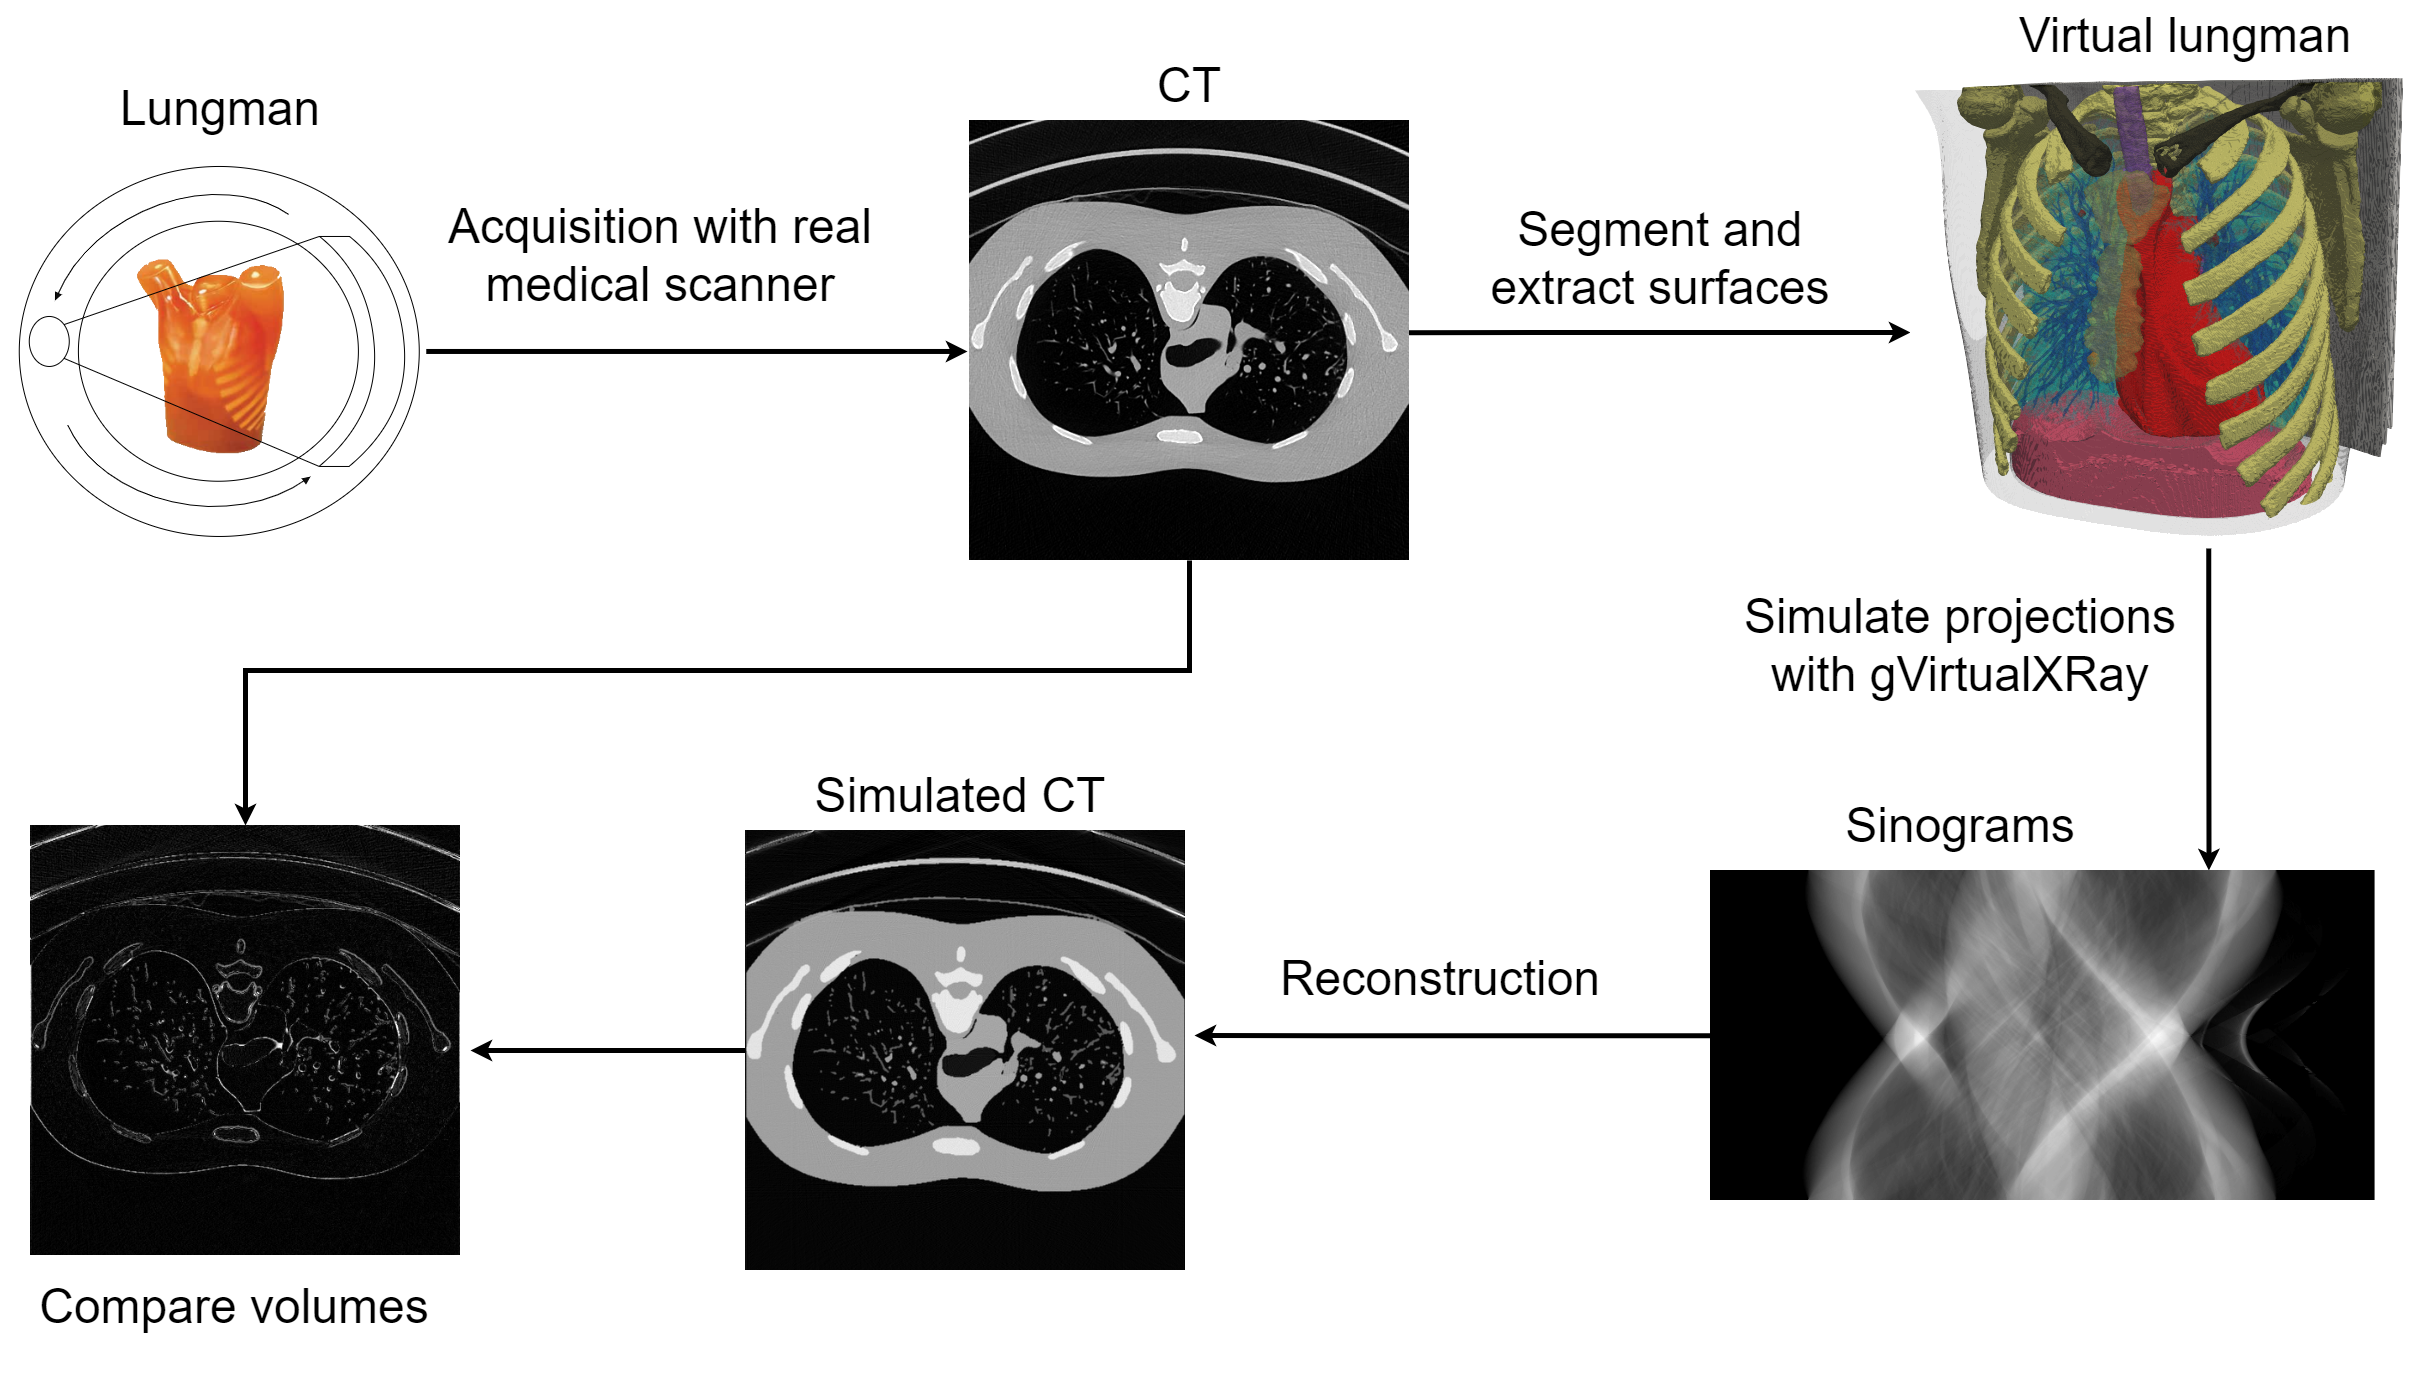

In [2]:
Image("../doc/gvxrflow.drawio.png", width=800)

**Methods and materials:** The setup for gVirtualXRay involved a sample centered about the origin, placing the source 500mm away from the object (SOD) and the detector also 500mm away (SDD). \
The beam is monochromatic with photons having 72keV of energy. A parallel beam is used in this experiment for simplicity because recovering the parameters from the original acquisition with the medical scanner would be difficult. \
The detector is set-up to best match the reference CT accounting for pixel size, resulting in the detector being approximately 453mm wide and 298mm tall. A width of 725 ($512 \times \sqrt{2}$) pixels is used instead of the 512 pixels found in the reference CT so the inscribed circle can be removed during the reconstruction process.

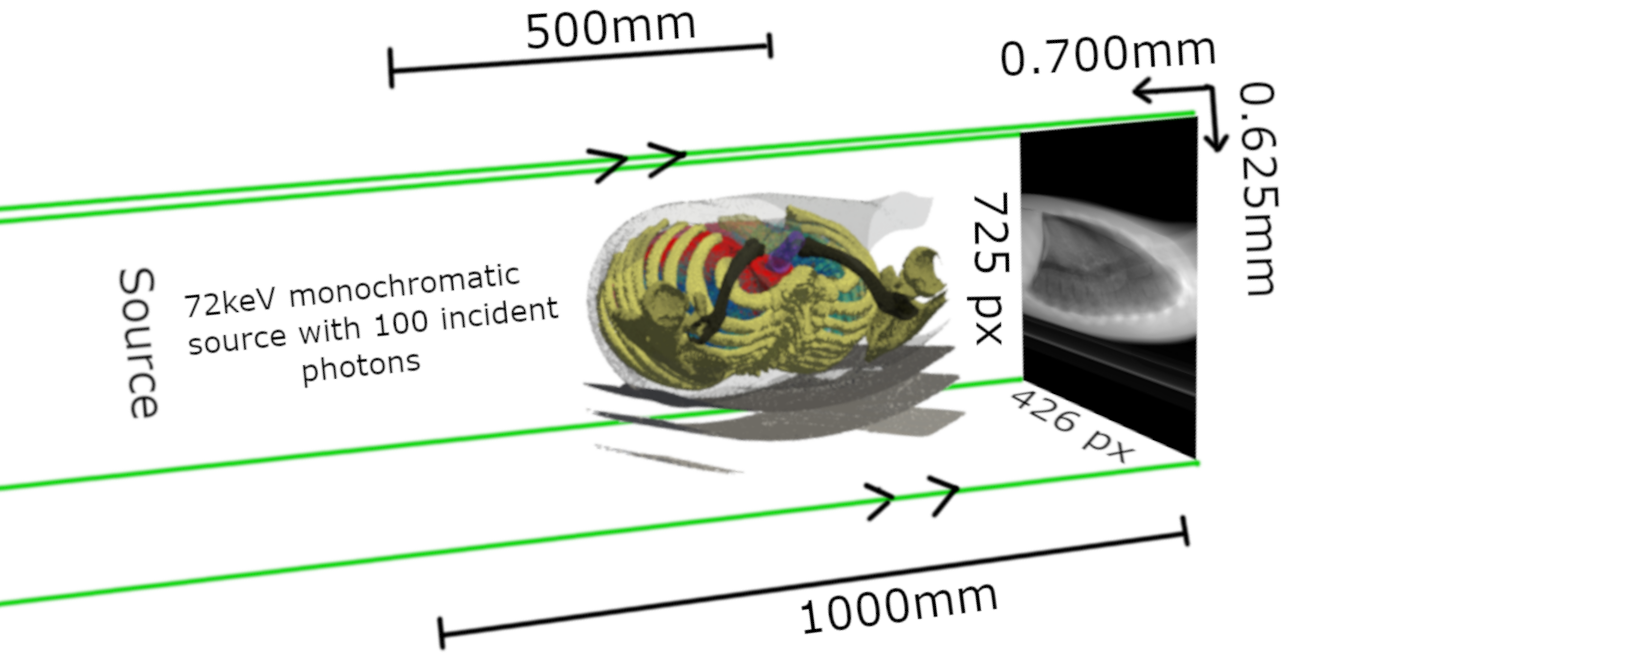

In [3]:
Image("../doc/gvxr-lungman-environment.png", width=800)

In [25]:
#with open('../doc/chest-paraview.gif','rb') as f:
#   display(Image(data=f.read(), format='png', width=480))

# Results

**Diagonal plot comparison**\
These two plots are sampled from the diagonal pixels of slice 150 from both the ground truth CT and simulated CT of the chest phantom.\
<span style="color:green">Green</span>: Ground truth CT plot\
<span style="color:red">Red</span>: Simulated CT plot\
This experiment proves the most significant changes in attenuation are accurately simulated. The simulated CT appears less noisy presumably because our experiment does not account for the natural deviation of image quality that comes with real equipment.

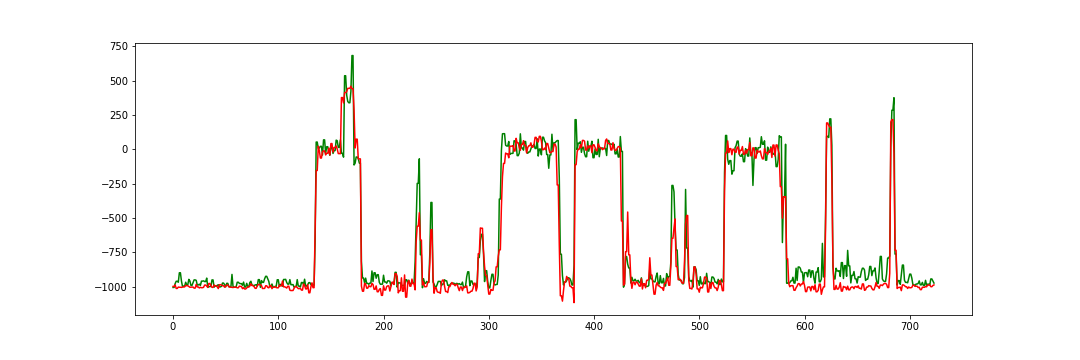

In [24]:
Image("./plots/diagonal-plots-chest-CT.png")

**Quantitative comparisons**\
From qauntative measures we achieved: a ZNCC score of 0.977 (97.7% similarity), a MAPE/MAPD 0.293 and a SSIM score of 0.911. For reference, a good ZNCC and SSIM score is 1 and a good MAPE score is 0.

# Import packages

In [6]:
import SimpleITK as sitk
import numpy as np
import numpy.ma as ma # Masking
from utils import *
from convertRaw import *
import gvxrPython3 as gvxr
import json2gvxr
import matplotlib.pyplot as plt
from tifffile import imread, imsave # Load/Write TIFF file
from threading import Thread
from skimage.transform import iradon
from sitk2vtk import *
from sklearn.metrics import mean_absolute_percentage_error as mape
from skimage.metrics import structural_similarity as ssim
#import scipy
import os
import math
import zipfile

SimpleGVXR 1.0.1 (2021-12-06T23:05:25) [Compiler: Microsoft Visual Studio] on Windows
gVirtualXRay core library (gvxr) 1.1.5 (2021-12-06T23:05:24) [Compiler: Microsoft Visual Studio] on Windows


# Performance
* The number of threads chosen will largely dictate the speed of reconstruction.
* The number of projections will affect the quality of the reconstruction.
* Artefact filtering, as you can expect, provides better quality image at the expense of speed.
* Artefact filtering on the GPU gives a decent compromise of speed to quality.

In [7]:
NUM_RECON_THREADS = 12;
#NUM_PROJECTIONS = 804;
#NUM_PROJECTIONS = 1600;
NUM_PROJECTIONS = 180;

DO_ARTEFACT_FILTERING_ON_CPU = False
DO_ARTEFACT_FILTERING_ON_GPU = False

ray_energy = 72

# Extract data for this experiment
The labelled volumes are provided compressed in a zip file. Use this procedure to extract the surfaces and masks needed for this notebook.

In [8]:
# Uncompress the labels
if (False == os.path.isfile("./lungman_data/segmentation-uncompressed/labels.mha")):
    with zipfile.ZipFile(  "./lungman_data/segmentation-compressed.zip", 'r') as myzip:
        myzip.extractall(  "./lungman_data/segmentation-uncompressed")

# Read the records for isovalue, average HU
mapHandle = open("./lungman_data/segmentation-uncompressed\map.dat");
bytes = mapHandle.read();
split_lines = bytes.split('\n');
bytes = None;
mapHandle.close();

# Read labels
rd = vtk.vtkMetaImageReader();
label_rel_path = "./lungman_data/segmentation-uncompressed/labels.mha";
rd.SetFileName(label_rel_path);
rd.Update()
vtkLabels = rd.GetOutput();

# Create threshold filter
threshold = vtk.vtkImageThreshold();
threshold.SetInputData(vtkLabels);
threshold.SetReplaceOut(0);
threshold.ReplaceOutOn()
threshold.ReplaceInOff();

for i in range(0, len(split_lines)):
    
    tuple_parts = split_lines[i].split('\t');
    
    # See if the surface already exists
    stl_rel_path = "./lungman_data/meshes/" + tuple_parts[2][0:-4] + ".stl";
    if (True == os.path.isfile(stl_rel_path)): continue;
    
    # Threshold to get label
    isovalue = int(tuple_parts[0]);
    threshold.ThresholdBetween(isovalue, isovalue);
    threshold.Update();
    vtkIm = threshold.GetOutput();
    
    # Extract surface and save
    vtkSurface = extractSurface(vtkIm, isovalue);
    writeSTL(vtkSurface, stl_rel_path);
    vtkSurface = None;
    vtkIm = None;
    
    

rd = None;


# Configure gVirtualXRay environment
**Create an OpenGL context and window.**

In [9]:
json2gvxr.initGVXR("notebook-10.json", "OPENGL");

Create an OpenGL context: 512x512


**Create a parallel photon beam.**

In [10]:
json2gvxr.initSourceGeometry();
gvxr.setMonoChromatic(ray_energy, "keV", 100);
gvxr.useParallelBeam();

Set up the beam
	Source position: [0, -500, 0, 'mm']
	Source shape: ParallelBeam


**Create a detector array.**

In [11]:
json2gvxr.initDetector("notebook-10.json");

Set up the detector
	Detector position: [0, 500, 0, 'mm']
	Detector up vector: [0, 0, 1]
	Detector number of pixels: [725, 426]
	Pixel spacing: [0.625, 0.7, 'mm']


**Create a phantom model from each mesh and its material.**

In [12]:
json2gvxr.initSamples("notebook-10.json", 1);

Load the 3D data

	Load 100HU_tumours in lungman_data/meshes/tumours_100HU.stl using mm
	Load -630HU_tumours in lungman_data/meshes/tumours_630HU.stl using mm
	Load Clavicle in lungman_data/meshes/clavicle.stl using mm
	Load Heart in lungman_data/meshes/heart.stl using mm
	Load Bronchus in lungman_data/meshes/bronchus.stl using mm
	Load Diaphram in lungman_data/meshes/diaphram.stl using mm
	Load Bronchioles in lungman_data/meshes/bronchioles.stl using mm
	Load Ribs_Spine in lungman_data/meshes/ribs_spine.stl using mm
	Load Scapulas in lungman_data/meshes/scapulas.stl using mm
	Load Sheets_high in lungman_data/meshes/sheets_high.stl using mm
	Load Sheets_low in lungman_data/meshes/sheets_low.stl using mm
	Load Sheets_med in lungman_data/meshes/sheets_med.stl using mm
	Load Skin in lungman_data/meshes/skin.stl using mm
	Load Sternum in lungman_data/meshes/sternum.stl using mm
	Load Trachea in lungman_data/meshes/trachea.stl using mm


**Visualise a single projection**

(-0.5, 511.5, 511.5, -0.5)

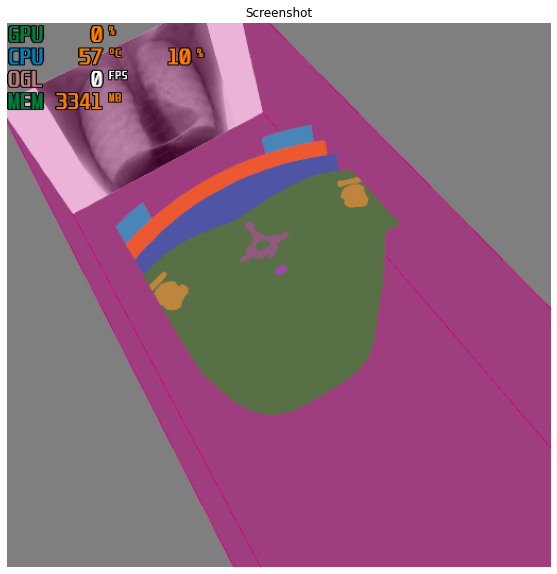

In [13]:
gvxr.computeXRayImage()
gvxr.displayScene()

# Give each mesh an alpha value
alpha = 0.2;
for i in range(gvxr.getNumberOfChildren('root')):
    label = gvxr.getChildLabel('root', i);
    pRGBA = gvxr.getAmbientColour(label);
    gvxr.setColour(label, pRGBA[0], pRGBA[1], pRGBA[2],alpha);

gvxr.useLighing(False)
gvxr.useWireframe(False)
gvxr.setZoom(1000)
gvxr.setSceneRotationMatrix([ 0.8535534,  0.5000000, -0.1464466,0,
  -0.5000000,  0.7071068, -0.5000000,0,
  -0.1464466,  0.5000000,  0.8535534,0,
                            0.0, 0.0, 0.0, 1.0])
gvxr.displayScene()


screenshot = gvxr.takeScreenshot()

plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')


# Do projections

Every epoch, the scene is rotated by a step such that the number of chosen projections is reached over 180 degrees and an image is produced on the detector array. At the end a set of X-Ray images is obtained in likeness to the raw data produced by a medical scanner except sliced in a different direction.

In [14]:

if      (DO_ARTEFACT_FILTERING_ON_GPU): gvxr.enableArtefactFilteringOnGPU();
elif    (DO_ARTEFACT_FILTERING_ON_CPU): gvxr.enableArtefactFilteringOnCPU();

# The change in angle between each projection to reach 180 degrees
angular_step = 180 / NUM_PROJECTIONS;
angle = 0;
g_theta = [];
projection_set =[];
for i in range(0, NUM_PROJECTIONS):
    # Rotate the scene
    gvxr.resetSceneTransformation();
    gvxr.rotateScene(angle, 0, 0, 1);
    # Capture the image
    xray_image = gvxr.computeXRayImage();
    projection_set.append(xray_image);
    
    # Record the theta for this image, this will be used during reconstruction
    g_theta.append(angle);
    angle += angular_step;

#projection_set = gvxr.computeProjectionSet(0, 0, 0, "mm", NUM_PROJECTIONS, angular_step);

projection_set = np.array(projection_set);

# Convert from the default unit of energy to keV
projection_set = projection_set / gvxr.getUnitOfEnergy("keV");

gvxr.destroyAllWindows();

# Correct flat-field

Taking advantage of the detector response when there is no sample can help improve the quality of images when a sample is present. To elaborate, any variance between pixels when the detector is dark (X-Ray beam off) or full (X-Ray beam on) with no density will affect the quality of images with a sample. Factoring for this systematic error is called flat-field correction. \
N: corrected image\
P: projection\
D: dark field\
F: full field\
$N = \frac{P - D}{F - D}$\
In this routine the projection data is flat-fielded.



In [15]:
# Create a mock dark field image
dark_field_image = np.zeros(projection_set.shape);

# Create a mock flat field image
flat_field_image = np.ones(projection_set.shape);

# Retrieve the total energy
total_energy = 0.0;
energy_bins = gvxr.getEnergyBins("keV");
photon_count_per_bin = gvxr.getPhotonCountEnergyBins();

for energy, count in zip(energy_bins, photon_count_per_bin):
    total_energy += energy * count;
flat_field_image *= total_energy;
    
# Apply the actual flat-field correction on the raw projections
projection_set = (projection_set - dark_field_image) / (flat_field_image - dark_field_image)

dark_field_image = None
flat_field_image = None

# Negative log normalisation

In [16]:
# Make sure no value is negative or null (because of the log function)
# It should not be the case, however, when the Laplacian is used to simulate
# phase contrast, negative values can be generated.
threshold = 0.000000001
projection_set[projection_set < threshold] = threshold;

# Apply the minus log normalisation
projection_set = -np.log(projection_set);

# Rescale the data taking into account the pixel size
pixel_spacing_in_mm = gvxr.getDetectorSize("mm")[0] / gvxr.getDetectorNumberOfPixels()[0]
projection_set /= pixel_spacing_in_mm * (gvxr.getUnitOfLength("mm") / gvxr.getUnitOfLength("cm"));

# Make sure the data is in single-precision floating-point numbers
projection_set = np.array(projection_set).astype(np.single)

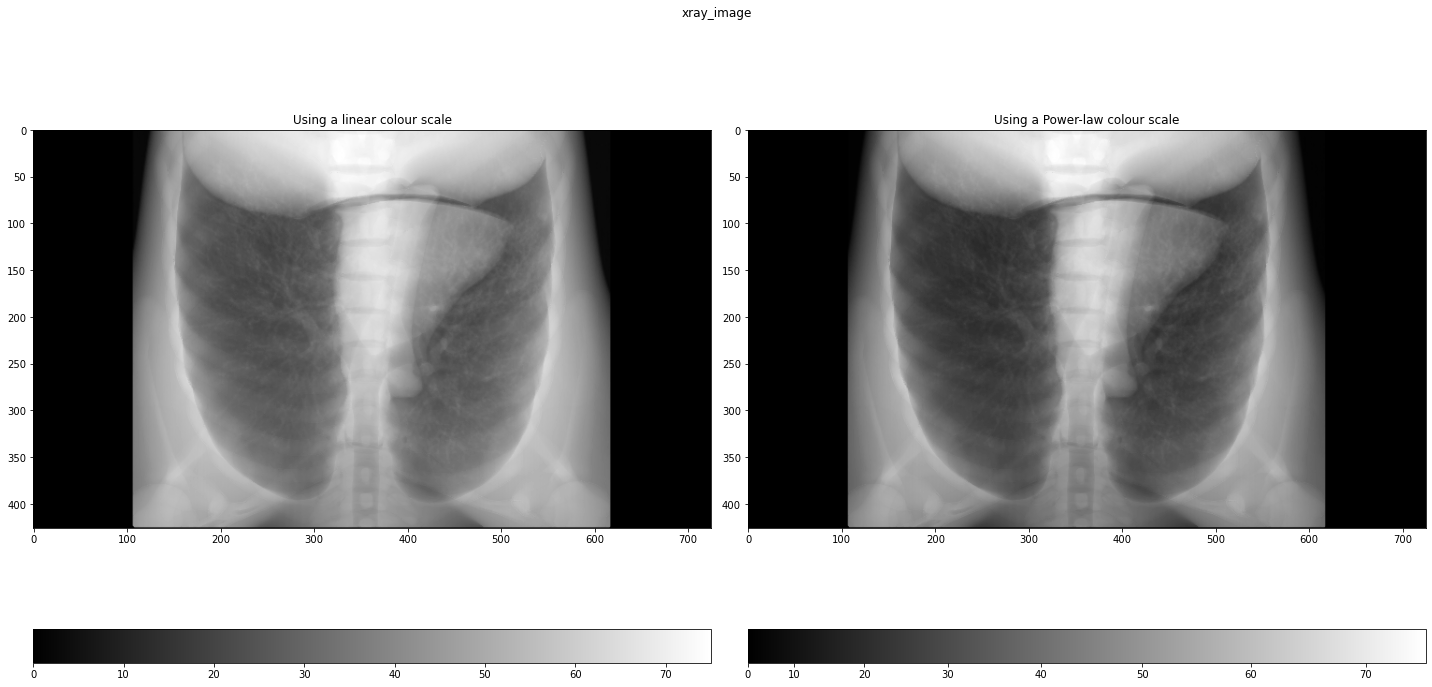

In [17]:
displayLinearPowerScales(projection_set[0], "xray_image", "plots/xray_image");

**Slice to get set of sinograms**

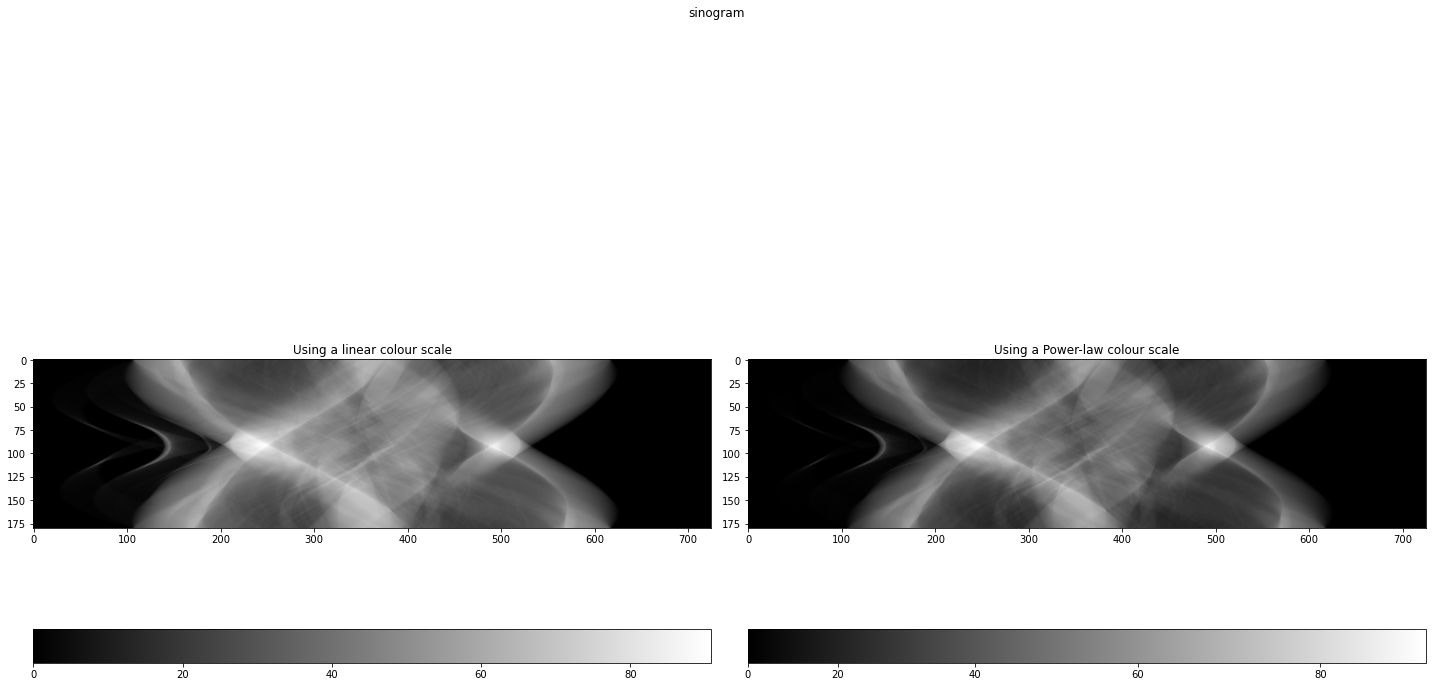

In [18]:
projection_set = np.swapaxes(projection_set, 0, 1);
displayLinearPowerScales(projection_set[len(projection_set) >> 1], "sinogram", "plots/test");

# Reconstruct CT

We used ski-kit image's iradon transform to reconstruct each CT slice from sinogram data. Because of how much data is being processed here, the option to use threading (use NUM_RECON_THREADS) was implemented which should speed things up on modern processors. At the end of this routine the CT is finally created.

**Create the reconstruction thread routine**

In [19]:
def recon(sinograms, CT_to_append_to, theta, iStart, iEnd):
    for i in range(iStart, iEnd):
        data = np.copy(sinograms[i].T);
        slice = iradon(data, theta=theta, circle=False);
        CT_to_append_to[i] = slice;
        format = "reconstructed slice {iSlice}";
        print(format.format(iSlice =i));

**Assign each thread work and create CT**

In [20]:

num_projections = len(projection_set);
Simulated_CT_in_MU = [None] * num_projections;
handle_recon_threads = [];
iThreadIdx = 0;

# The number of slices each thread will reconstruct
num_slices_per_thread = (int)(num_projections / NUM_RECON_THREADS)

for i in range(0, num_projections):
    
    if i % num_slices_per_thread == 0 and iThreadIdx < NUM_RECON_THREADS:
        
        # The last thread will have to pick up the remaining slices
        if (iThreadIdx == NUM_RECON_THREADS - 1): iEnd = len(projection_set); 
        else:                                     iEnd = i + num_slices_per_thread;
        
        # Set up the thread
        handle_recon_threads.append(Thread(target=recon, 
                                           args=(projection_set, 
                                                 Simulated_CT_in_MU, 
                                                 g_theta, 
                                                 i, iEnd)));
        handle_recon_threads[iThreadIdx].start()
        iThreadIdx+=1;
        format = "Starting thread {iThreadNum}";
        print(format.format(iThreadNum =iThreadIdx));
   

# Wait for the threads to complete
for i in range(len(handle_recon_threads)):
    handle_recon_threads[i].join()
    


Starting thread 1
Starting thread 2
Starting thread 3
Starting thread 4
Starting thread 5
Starting thread 6
Starting thread 7
Starting thread 8
Starting thread 9
Starting thread 10
Starting thread 11
Starting thread 12
reconstructed slice 385
reconstructed slice 140
reconstructed slice 350
reconstructed slice 70
reconstructed slice 175
reconstructed slice 0reconstructed slice 35reconstructed slice 105


reconstructed slice 280
reconstructed slice 210reconstructed slice 245

reconstructed slice 315
reconstructed slice 141
reconstructed slice 386
reconstructed slice 176
reconstructed slice 1
reconstructed slice 351
reconstructed slice 36
reconstructed slice 71
reconstructed slice 106
reconstructed slice 211
reconstructed slice 281
reconstructed slice 246
reconstructed slice 316
reconstructed slice 2
reconstructed slice 212
reconstructed slice 142
reconstructed slice 247
reconstructed slice 37
reconstructed slice 387
reconstructed slice 177
reconstructed slice 72reconstructed slice 352rec

reconstructed slice 63
reconstructed slice 273
reconstructed slice 413
reconstructed slice 203
reconstructed slice 133
reconstructed slice 343
reconstructed slice 98
reconstructed slice 378
reconstructed slice 308
reconstructed slice 29
reconstructed slice 168
reconstructed slice 239
reconstructed slice 64
reconstructed slice 274
reconstructed slice 414
reconstructed slice 204
reconstructed slice 134
reconstructed slice 344
reconstructed slice 99
reconstructed slice 379
reconstructed slice 309
reconstructed slice 30
reconstructed slice 169
reconstructed slice 240
reconstructed slice 65
reconstructed slice 275
reconstructed slice 415
reconstructed slice 205
reconstructed slice 135
reconstructed slice 345
reconstructed slice 100
reconstructed slice 380
reconstructed slice 310
reconstructed slice 31
reconstructed slice 170
reconstructed slice 241
reconstructed slice 66
reconstructed slice 416
reconstructed slice 276
reconstructed slice 206
reconstructed slice 136
reconstructed slice 346
r

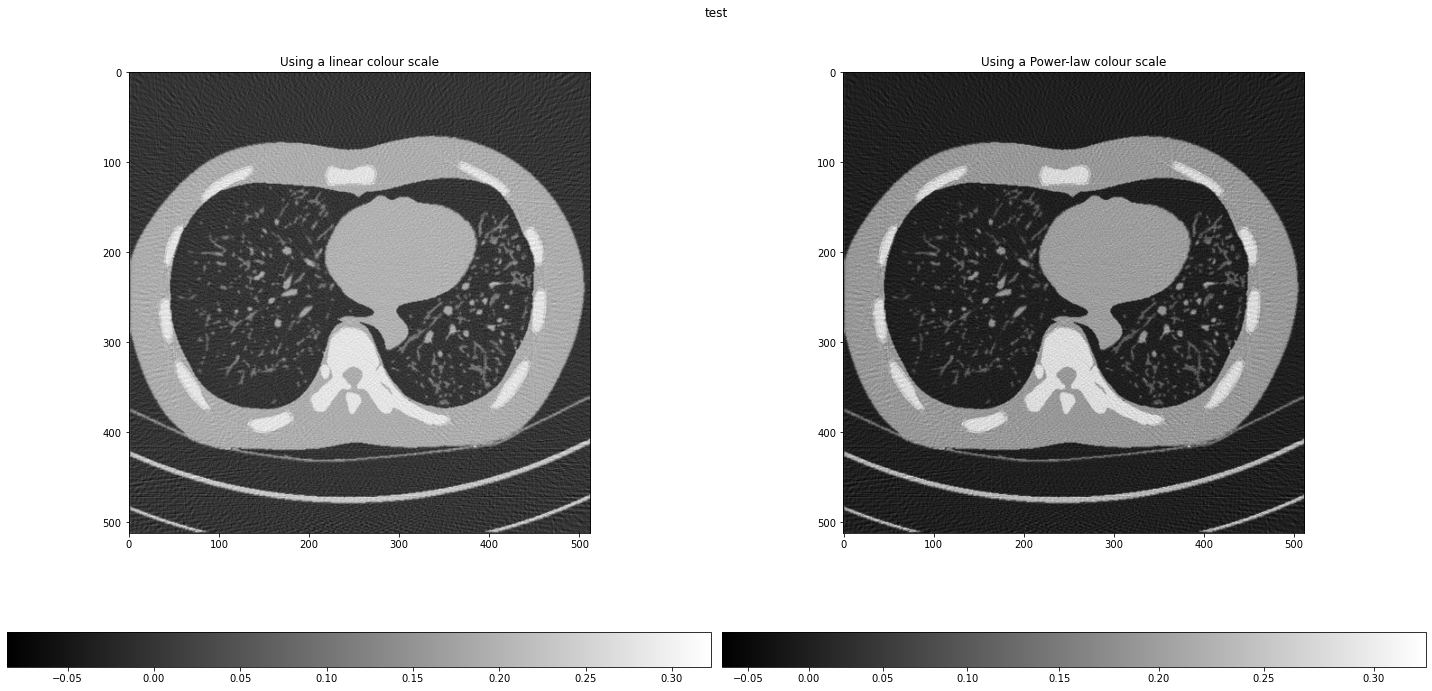

In [21]:
displayLinearPowerScales(Simulated_CT_in_MU[150], "test", "plots/test");
    

# Transform to Hounsfield units
The hounsfield unit (HU) is frequently used in radiography as a means to standardise radiodensity. On the hounsfield scale, water has a HU of 0 and air -1000. Each pixel in a radiography image corresponds to the photons linear attenuation coefficient or $\mu$. The transformation for each voxel is as follows.


<center>$HU = 100 \times \frac{\mu - \mu _{water}}{\mu _{water} - \mu _{air}}$</center>

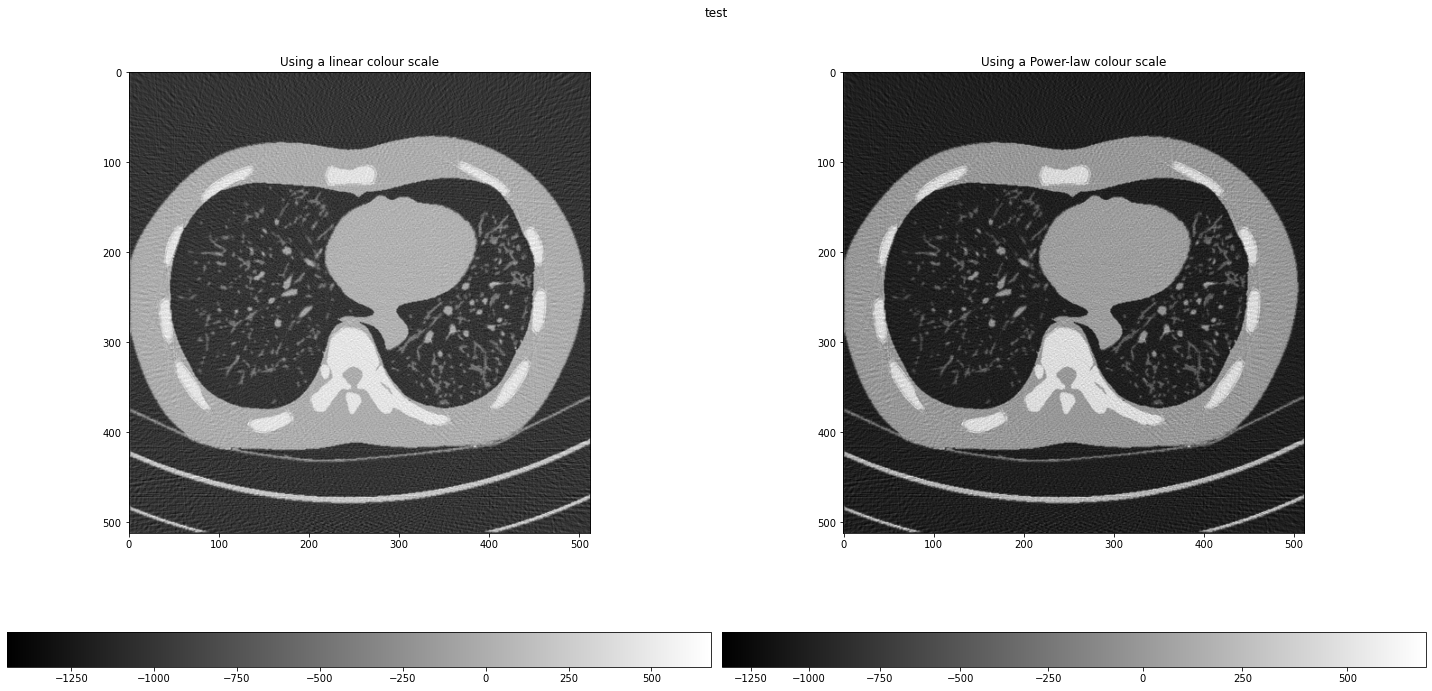

In [22]:
MU_air = gvxr.getMuFromHU(-1000.0, ray_energy, "keV");
MU_water = gvxr.getMuFromHU(0, ray_energy, "keV");

Simulated_CT_in_MU = np.array(Simulated_CT_in_MU);

Simulated_CT_in_HU = 1000.0 * ((Simulated_CT_in_MU - MU_water) / (MU_water - MU_air));
displayLinearPowerScales(Simulated_CT_in_HU[150], "test", "plots/test");

Simulated_CT_in_MU = None;

Read the CT volume of the chest phantom acquired using the medical scanner.

In [23]:
# Read the reference CT
sitk_reader = sitk.ImageFileReader();
sitk_reader.SetImageIO("MetaImageIO");
sitk_reader.SetFileName("lungman_data/lungman.mha");
Ground_truth_CT = np.array(sitk.GetArrayFromImage(sitk_reader.Execute()));

# Make sure each volume has floating point precision
Ground_truth_CT = Ground_truth_CT.astype(np.single);
Simulated_CT_in_HU = Simulated_CT_in_HU.astype(np.single);

RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: D:\a\1\sitk-build\ITK\Modules\IO\Meta\src\itkMetaImageIO.cxx:101:
ITK ERROR: MetaImageIO(000001984BB4B6A0): File cannot be read: lungman_data/lungman.mha for reading.
Reason: No such file or directory

# Visual comparisons

**Checkerboard and absolute difference**\
For the first comparison, the 150th slice of the ground and simulated CT is observed. Each slice is normalised for visual comparisons using the formula.
<center>$f _{i,j} = \frac{f _{i,j} - \bar{f}}{\sigma _{f}}$</center>

In [ ]:
im2 = Simulated_CT_in_HU[150].astype(np.single);
im1 = Ground_truth_CT[150].astype(np.single);
std1 = np.std(im1);
std2 = np.std(im2);
im1 = (im1 - np.mean(im1)) / (std1);
im2 = (im2 - np.mean(im2)) / (std2);
im1[im1 == 0] = 0.00001;
im2[im2 == 0] = 0.00001;

In [ ]:
fullCompareImages(im1, im2, "test","plots/test");

**Diagonal plots**\
It is easier to observe changes in intensity by plotting samples of intensity from compared slices. For the clearest plot, the samples are reduced to being over a diagonal line drawn from the top-left to bottom-right of the image.

In [ ]:
shape = np.shape(Ground_truth_CT);

#Number of samples is equal to the number of pixels on the diagonal
num_plot_samples = math.sqrt((shape[1] ** 2) + (shape[2] ** 2));
num_plot_samples = int(num_plot_samples);


ground_slice = Ground_truth_CT[150];
simulated_slice = Simulated_CT_in_HU[150];
ground_samples = [0] * num_plot_samples;
simulated_samples = [0] * num_plot_samples;
iStep = float(shape[1]) / float(num_plot_samples);
jStep = float(shape[2]) / float(num_plot_samples);
fI = 0.0; fJ = 0.0;
l = 0;
i = 0; j = 0;
while (l < num_plot_samples):
    ground_samples[l] = ground_slice[i][j];
    simulated_samples[l] = simulated_slice[i][j];
    fI += iStep;
    fJ += jStep;
    i = math.floor(fI);
    j = math.floor(fJ);
    l+=1;
    
plt.figure(figsize=(15,5))
plt.plot(ground_samples, 'g');
plt.plot(simulated_samples, 'r');

plt.savefig('plots/comparison-CT-simulations.pdf', bbox_inches='tight')
plt.savefig('plots/comparison-CT-simulations.png')

# Quantifiable comparisons

**ZNCC**\
The zero mean normalised cross-correlation metric is valuable as a measure independant from an image's dynamic range and has the advantage of being able to be presented as a pecentage.

<center>$ZNCC(A,B) = \frac{1}{n(\sigma _{A} \sigma _{B})} \sum_{i = 0}^{n}{(A_{i} - \bar{A})(B_{i} - \bar{B})}$</center>

In [ ]:
def calculateZNCC(ground, predict):
    
    dims = np.shape(ground);
    denom = 1.0;
    i = 0;
    while (i < len(dims)):
        denom *= dims[i];
        i+=1;
        
    if (denom == 0): return 0;
    
    ground_std  = np.std(ground);
    predict_std = np.std(predict);
    denom *= (ground_std * predict_std)
    
    ground_mean = np.mean(ground);
    predict_mean = np.mean(predict);
    
    sum = np.sum(
            (ground  - ground_mean)
            *(predict - predict_mean)
            );
        
    zncc_score = sum / denom;
    return zncc_score

In [ ]:
zncc_score = calculateZNCC(Ground_truth_CT, Simulated_CT_in_HU)
format = "ZNCC score: {score:.3f}%";
print (format.format(score=zncc_score));

**MAPE**\
MAPE or MAPD is the second metric in this notebook.   

In [ ]:
def calculateMAPE(ground, predict):
    
    num_voxels = 1;
    dims = np.shape(ground);
    i = 0;
    while (i < len(dims)):
        num_voxels *= dims[i];
        i += 1;
        
    ground_flat = ground.ravel();#ground.flat;#ground.flatten();
    predict_flat =predict.ravel();#predict.flat;# predict.flatten();
    
    acc = 0;
    i = 0;
    while (i < num_voxels):
        ground_val = ground_flat[i];
        if (ground_val == 0): 
            ground_val = 1;
        #if (ground_val != 0):
        acc += (ground_val - predict_flat[i]) / ground_val;
        i+= 1;
        
    return acc / num_voxels;

In [ ]:
mape_score = calculateMAPE(Ground_truth_CT, Simulated_CT_in_HU);
format = "MAPE score: {score:.3f}%";
print (format.format(score=mape_score));
print(mape(Ground_truth_CT[50], Simulated_CT_in_HU[50]));

In [ ]:

num_slices = np.shape(Ground_truth_CT)[0];

ground_max = np.max(Ground_truth_CT);
simulated_max = np.max(Simulated_CT_in_HU);
ground_min = np.min(Ground_truth_CT);
simulated_min = np.min(Simulated_CT_in_HU);

max = ground_max if ground_max > simulated_max else simulated_max;
min = ground_min if ground_min < simulated_min else simulated_min;
range =  max - min;
acc = 0;
i = 0;
#High mem when doing whole volume so...
while(i < num_slices):
    acc += ssim(Ground_truth_CT[i], Simulated_CT_in_HU[i], data_range=range);
    i+=1;

ssim_score = acc / num_slices;

format = "SSIM score: {score:.3f}%";
print (format.format(score=ssim_score));

In [ ]:
# Read the map for isovalue/label to average HU
sitk_meta_reader = sitk.ImageFileReader();
sitk_meta_reader.SetImageIO("MetaImageIO");
mapHandle = open("./lungman_data/segmentation-uncompressed/map.dat");
bytes = mapHandle.read();
split_lines = bytes.split('\n');
bytes = None;
mapHandle.close();

# Read the labbeled volume
label_rel_path = "./lungman_data/segmentation-uncompressed/labels.mha" ;#+ tuple_parts[2];
sitk_meta_reader.SetFileName(label_rel_path);
labels = sitk_meta_reader.Execute();

# Create the binary erosion filter
erode = sitk.BinaryErodeImageFilter();

acc_avg_rel_diff = 0;
vec_avg_rel_diff = [];
i = 0;
print("Name\t\tRelative Error\tAbsolute Error");
while ( i < len(split_lines)):
   
    tuple_parts = split_lines[i].split('\t');
    
    name = tuple_parts[2][0:-4];
    kernel_radius = 2;
    
    # Sheets are too slim to be eroded so much
    if (name.find("sheet") != -1):
        kernel_radius = 1;
    
    # Erode the mask
    erode.SetKernelRadius(kernel_radius);
    erode.SetForegroundValue(int(tuple_parts[0]));
    sitk_mask = erode.Execute(labels);
        
    mask = np.array(sitk.GetArrayFromImage(sitk_mask));
    sitk_mask = None
   
    # Apply mask to simulated CT
    simulated_masked = Simulated_CT_in_HU[mask == int(tuple_parts[0])];#ma.masked_where(mask > 0, Simulated_CT_in_HU)
    
    avg_simulated_HU = np.mean(simulated_masked);
    avg_ground_HU = float(tuple_parts[1]);
    avg_rel_diff = (avg_ground_HU - avg_simulated_HU) / avg_ground_HU;
    avg_rel_diff *= 100.0;
    abs_diff =  abs(avg_simulated_HU - avg_ground_HU);
    format = "{structure:<15}\t{rel:<15.3f}\t{abs:.3f}";
    print(format.format(structure=name, rel=avg_rel_diff, abs=abs_diff));
    
    acc_avg_rel_diff += abs(avg_rel_diff);
    vec_avg_rel_diff.append(acc_avg_rel_diff);
    i+=1;
    
avg_rel_diff = acc_avg_rel_diff / len(vec_avg_rel_diff);
print('\n')
format = "Average relative error = {error:.3f}%";
print(format.format(error=avg_rel_diff));